In [1]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import neurokit2 as nk
import heartpy as hp
from statistics import mean
import functions
from multiprocessing import Pool
from datetime import time
from pandarallel import pandarallel
import functions
import scipy
import math
import pywt
import operator
from functions import *
import itertools
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
folder = ""
raw = folder + "raw_data/"
x_train = pd.read_csv('x_train_preprocess.csv')
x_test = pd.read_csv('x_test_preprocess.csv')
y_train = pd.read_csv(raw + 'y_train.csv', index_col=['id'])
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

In [3]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117 entries, 0 to 5116
Columns: 1009 entries, Unnamed: 0 to nk_feat_387
dtypes: float64(1008), int64(1)
memory usage: 39.4 MB


In [4]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=400, random_state=42)
clf.fit(x_train)
y_pred_train = clf.predict(x_train)
scores = clf.decision_function(x_train)
#count anomalies
anomalies = 0
for i in y_pred_train:
    if i == -1:
        anomalies += 1
print(anomalies)
#remove anomalies
#x_train = x_train[y_pred_train == 1]
#y_train = y_train[y_pred_train == 1]  

178


In [5]:
selector = SelectKBest(score_func=f_classif, k=300)
selector.fit(np.array(x_train), np.array(y_train).squeeze())
cols = selector.get_support(indices=True)

/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [72] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


In [6]:
#x_train= x_train.iloc[:,cols]
#x_test = x_test.iloc[:,cols]

In [7]:
#feature reduction with pca
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(x_train)
#x_train = pca.transform(x_train)
#x_test = pca.transform(x_test)

PCA(n_components=200)

In [8]:
#scale data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [9]:
import xgboost as xgb
from sklearn.metrics import f1_score
clf = xgb.XGBClassifier(n_estimators=100,objective="multi:softmax", random_state=42, eval_metric=f1_score)

In [10]:
#cross validation score
scores = cross_val_score(clf, x_train, np.ravel(y_train), cv=10, scoring='f1_micro', n_jobs=8)
print(scores.mean())
print(scores.std())
#0.6994274400684931 StandardScaler
#0.6996231347847358 / 0.01592645870348861  MinMaxScaler
#0.6818420529598825 PCA 100
#0.6794921875 PCA 100
#0.7168178968933464 / 0.01259941801705392 new preprocessing
#0.7381195725293541 / 0.014691595901730966 378 features
#0.8133664842221136 / 0.0056350137026039354

0.8133664842221136
0.0056350137026039354


In [11]:
#save the model with pickle
import pickle
filename = 'models/xgboost_model.sav'
pickle.dump(clf, open(filename, 'wb'))


In [12]:
clf.fit(x_train, np.ravel(y_train))
y_test = clf.predict(x_test)
data_y_test = {
    'id': [i for i in range(len(y_test))],
    'y': y_test
}
df_y_test = pd.DataFrame(data_y_test)
df_y_test.to_csv('outputs/output_xgb.csv', index=False)

In [13]:
#feature importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 969 (0.032765)
2. feature 344 (0.018987)
3. feature 334 (0.012513)
4. feature 509 (0.012424)
5. feature 804 (0.011911)
6. feature 167 (0.011887)
7. feature 327 (0.011816)
8. feature 428 (0.011377)
9. feature 590 (0.008813)
10. feature 587 (0.007546)
11. feature 392 (0.007158)
12. feature 11 (0.007029)
13. feature 557 (0.006923)
14. feature 657 (0.006886)
15. feature 559 (0.006211)
16. feature 95 (0.005875)
17. feature 17 (0.005446)
18. feature 340 (0.005424)
19. feature 576 (0.005413)
20. feature 15 (0.005409)
21. feature 16 (0.005358)
22. feature 325 (0.005048)
23. feature 965 (0.004925)
24. feature 212 (0.004566)
25. feature 20 (0.004437)
26. feature 6 (0.004410)
27. feature 857 (0.004361)
28. feature 257 (0.004357)
29. feature 670 (0.004216)
30. feature 5 (0.004120)
31. feature 671 (0.003950)
32. feature 389 (0.003795)
33. feature 605 (0.003761)
34. feature 805 (0.003729)
35. feature 312 (0.003358)
36. feature 296 (0.003152)
37. feature 667 (0.003151)
38.

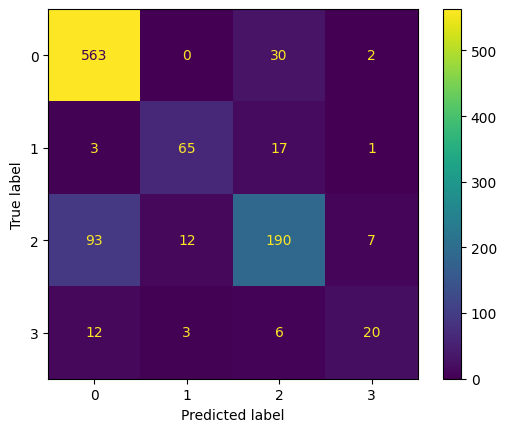

In [14]:
#obtain validation set
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
clf.fit(x_train_2, np.ravel(y_train_2))
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import metrics
y_pred = clf.predict(x_val)
cm = metrics.confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()